<a href="https://colab.research.google.com/github/tewei0328/TS/blob/master/TS_RL1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning
- A blundering guide to making a deep actor-critic bot for stock trading (為股票交易打造深具演員批評的機器人的錯誤指導)
  - 技術分析處於一廂情願到瘋狂複雜數學的規模。如果數字有實際趨勢，而不論特定股票的基本面如何，那麼只要有足夠的函數逼近器（如深層神經網絡），強化學習就可以解決這個問題。
  - 這是一個有趣且可能有利可圖的項目，我嘗試這樣做。我與RL的合作不到六個月，但仍未解決問題，但是在為一些基本遊戲提供AI學習器之後，就應該優先考慮時間序列的股市數據。
  - 這並不容易，與其寫一篇文章向自己介紹一個解決了問題的專家，不如說是本文記錄了我在此過程中的過程和錯誤。
  - https://towardsdatascience.com/a-blundering-guide-to-making-a-deep-actor-critic-bot-for-stock-trading-c3591f7e29c2
  - https://github.com/tewei0328/RL-stocktrading
- An Overview of Deep Reinforcement Learning for Trading
  - https://www.mlq.ai/deep-reinforcement-learning-for-trading/

In [2]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical

In [3]:
torch.manual_seed(51)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
import quandl
#quandl.ApiConfig.api_key = "xxx"
apl_stock=quandl.get('WIKI/AAPL', start_date="2014-01-01", end_date="2018-08-20", )
msf_stock=quandl.get('WIKI/MSFT', start_date="2014-01-01", end_date="2018-08-20")
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
msf_open = msf_stock["Open"].values
msf_close = msf_stock["Close"].values

In [5]:
import pandas_datareader as pdr
startTime = '2015-01-01'
endTime = '2020-05-31'
apl_stock = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
msf_stock = pdr.DataReader('^TWII', 'yahoo', startTime, endTime)
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
msf_open = msf_stock["Open"].values
msf_close = msf_stock["Close"].values

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [6]:
msf_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-05,9292.309570,9182.019531,9292.309570,9274.110352,2311000.0,9274.076172
2015-01-06,9209.929688,9043.440430,9209.929688,9048.339844,2725800.0,9048.306641
2015-01-07,9108.660156,9050.540039,9051.940430,9080.089844,2384100.0,9080.055664
2015-01-08,9246.620117,9154.030273,9154.030273,9238.030273,2657600.0,9237.996094
2015-01-09,9284.570312,9215.580078,9247.400391,9215.580078,2398800.0,9215.545898


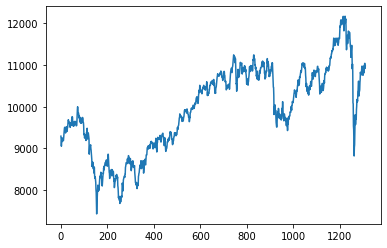

In [7]:
plt.plot(range(0, len(msf_open)), msf_open)

In [8]:
print(apl_open.min())
print(apl_close.min())
print(msf_open.min())
print(msf_close.min())

7427.35986328125
7410.33984375
7427.35986328125
7410.33984375


## Build the environment
- For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
- This starting cash is the mean starting cash; it can be randomized by altering the std parameter
- action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
- obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
- If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
- Buys and sells attract a 10% brokerage fee

In [9]:
class TradingEnvironment():

    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, \
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point
        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.starting_portfolio_value = self.portfolio_value()
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], msf_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean()
        msf5 = msf_open[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [10]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32)).cuda()
        
    def forward(self, x):
        x = torch.tensor(x).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

In [11]:
# 注意: 使用cuda前, colab要先選GPU
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
